In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/datasets/humanActivityRecognition/

/content/drive/MyDrive/datasets/humanActivityRecognition


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.feature_selection import RFE
import xgboost as xgb


from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [ ]:
#loading the dataset
train_data = pd.read_csv(r"train.csv")

In [ ]:
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [ ]:
print("Number of Rows",train_data.shape[0])
print("Number of columns",train_data.shape[1])

Number of Rows 7352
Number of columns 563


# **Data preprocessing**

Handling duplicate values in dataset

In [ ]:
train_data.duplicated().any()

False

In [ ]:
duplicated_columns = train_data.columns[train_data.T.duplicated()].tolist()
print("No. of duplicate columns: ", len(duplicated_columns))

No. of duplicate columns:  21


In [ ]:
train_data = train_data.drop(duplicated_columns,axis=1)
train_data.shape

(7352, 542)

Checking for missing/NaN values

In [ ]:
train_data.isnull().sum()

tBodyAcc-mean()-X       0
tBodyAcc-mean()-Y       0
tBodyAcc-mean()-Z       0
tBodyAcc-std()-X        0
tBodyAcc-std()-Y        0
                       ..
angle(X,gravityMean)    0
angle(Y,gravityMean)    0
angle(Z,gravityMean)    0
subject                 0
Activity                0
Length: 542, dtype: int64

Check for data imbalance

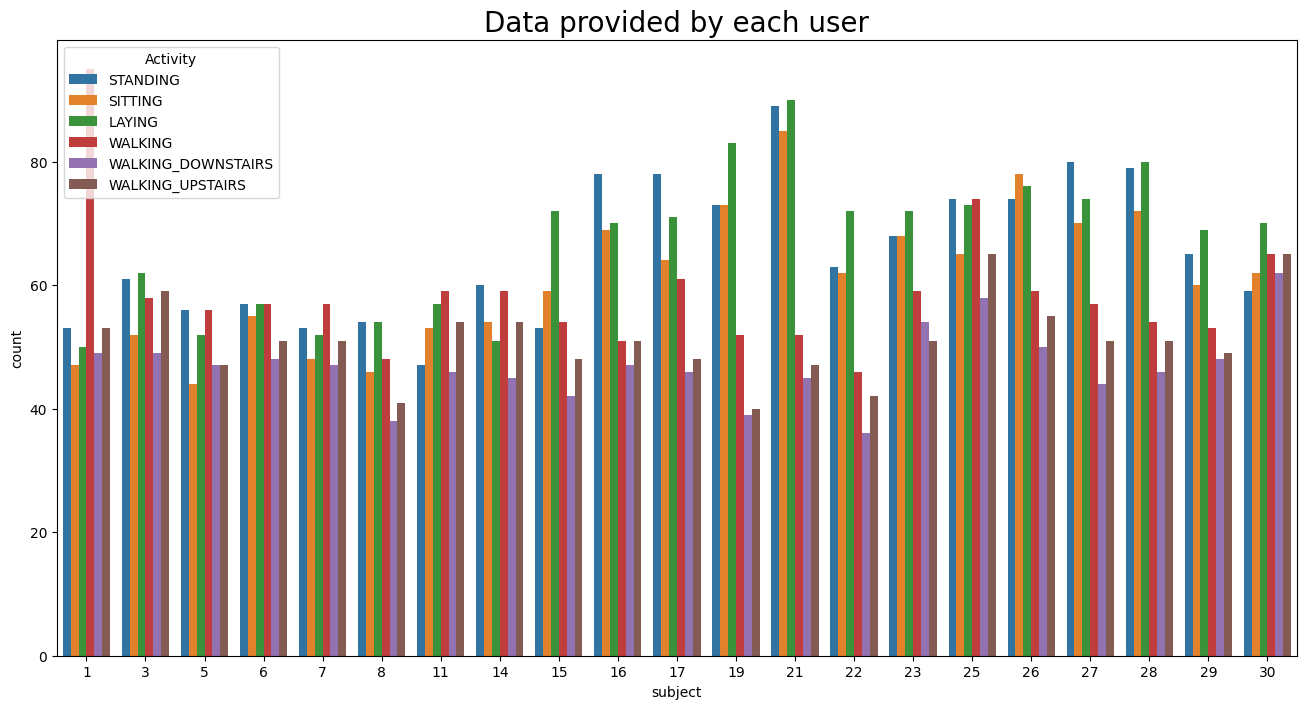

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Data provided by each user', fontsize=20)
sns.countplot(x='subject',hue=train_data['Activity'], data = train_data)
plt.show()

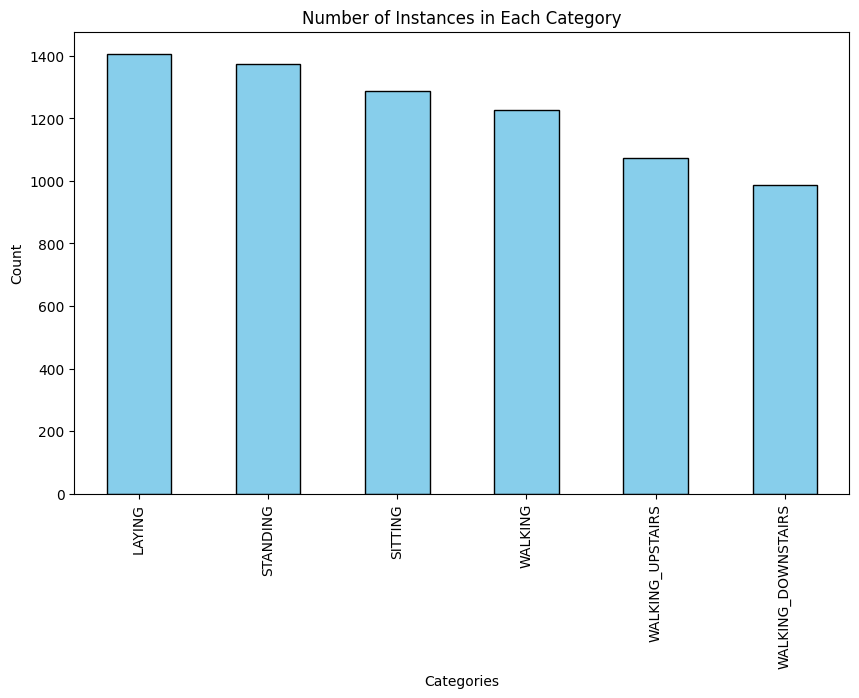

In [ ]:
# Count the number of instances of each category
category_counts = train_data['Activity'].value_counts()
# Plotting the bar plot
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Number of Instances in Each Category')

# Display the plot
plt.show()

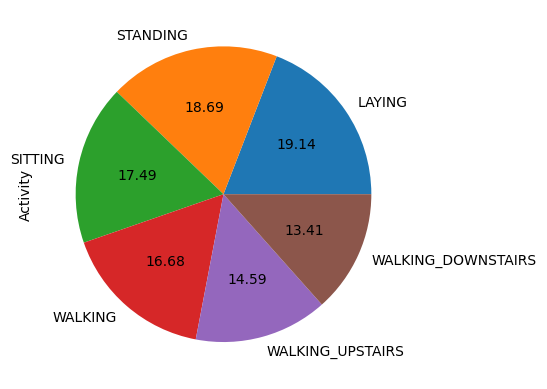

In [ ]:
plot_imb=train_data['Activity'].value_counts().plot.pie(autopct='%.2f')

In [ ]:
# separate features and target variables
X = train_data.drop('Activity',axis=1)
y= train_data['Activity']

# label the different categories of the target variable
le = LabelEncoder()
y = le.fit_transform(y)
print(y)

[2 2 2 ... 5 5 5]


In [ ]:
# split the dataset into training and test tests
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                               random_state=12)

# model prediction before feature filtering
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred_rf_bf = rf.predict(X_test)
accuracy_score(y_test, y_pred_rf_bf)

0.9802855200543847

# **Feature selection**

In [ ]:
# filter method for feature selection
filter_selector = SelectKBest(f_classif,k=200)
X_train_selected = filter_selector.fit_transform(X_train,y_train)
X_test_selected = filter_selector.transform(X_test)

selected_indices=filter_selector.get_support(indices=True)
selected_features = X_train.columns[selected_indices]
print(selected_features)

Index(['tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X', 'tBodyAcc-max()-Y', 'tBodyAcc-max()-Z',
       'tBodyAcc-min()-X',
       ...
       'fBodyBodyGyroMag-mad()', 'fBodyBodyGyroMag-iqr()',
       'fBodyBodyGyroMag-entropy()', 'fBodyBodyGyroJerkMag-mean()',
       'fBodyBodyGyroJerkMag-std()', 'fBodyBodyGyroJerkMag-mad()',
       'fBodyBodyGyroJerkMag-iqr()', 'fBodyBodyGyroJerkMag-entropy()',
       'angle(X,gravityMean)', 'angle(Y,gravityMean)'],
      dtype='object', length=200)


                           Features  Importances
186       fBodyBodyAccJerkMag-iqr()     0.000340
91            tBodyAccJerkMag-min()     0.000389
121                fBodyAcc-iqr()-Y     0.000395
83                tBodyAccMag-min()     0.000422
197  fBodyBodyGyroJerkMag-entropy()     0.000432
..                              ...          ...
199            angle(Y,gravityMean)     0.036709
19             tGravityAcc-mean()-X     0.036872
24              tGravityAcc-min()-Y     0.037878
198            angle(X,gravityMean)     0.039326
23              tGravityAcc-min()-X     0.048564

[200 rows x 2 columns]


<Axes: >

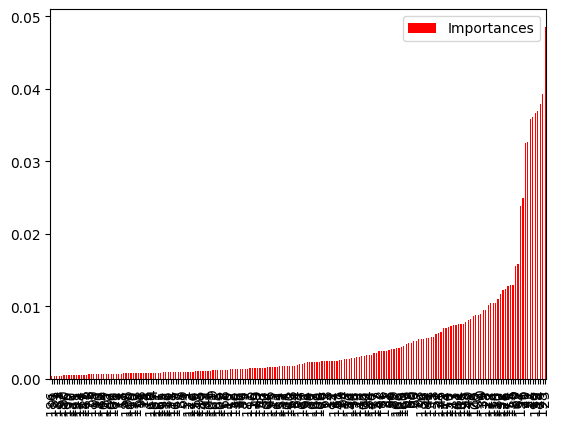

In [ ]:
#feature importance through random forest classifier

X_features = train_data[selected_features]
#creating random forest classifier
rf_clf = RandomForestClassifier(n_estimators=200, random_state=7)
rf_clf.fit(X_features, y)
#getting feature importances
feature_importances = rf_clf.feature_importances_

imp_fts = pd.DataFrame({"Features": pd.DataFrame(X_features).columns, "Importances": feature_importances})
# imp_fts.set_index('Importances')
imp_fts = imp_fts.sort_values('Importances')

print(imp_fts)

imp_fts.plot.bar(color='red')

In [ ]:
# selecting the 50 highest importance features
rf_imp_features = imp_fts.tail(50)

In [ ]:
rf_selected_features = rf_imp_features['Features']

In [ ]:
X_features_final = X_features[rf_selected_features]
X_features_final.shape

(7352, 50)

In [ ]:
# split the dataset into training and test tests
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_features_final, y, test_size=0.20,
                                               random_state=12)

# Normalising and Transforming data

scaler = MinMaxScaler()
scaler.fit(X_train_f)
scaler.data_max_
scaler.transform(X_train_f)

array([[0.07292195, 0.01920549, 0.0092549 , ..., 0.6819964 , 0.70173571,
        0.41093203],
       [0.24581274, 0.53838451, 0.54055479, ..., 0.30376724, 0.11648303,
        0.95526249],
       [0.25115873, 0.58766993, 0.36881791, ..., 0.19285357, 0.23419032,
        0.91465555],
       ...,
       [0.2549069 , 0.41805709, 0.23435157, ..., 0.27989815, 0.17596973,
        0.95293461],
       [0.22639523, 0.27775487, 0.27144981, ..., 0.29065214, 0.07530687,
        0.98628352],
       [0.05780614, 0.00230753, 0.0056252 , ..., 0.75682274, 0.80340157,
        0.27783072]])

# **Model training**

**Random Forest Classifier**

In [ ]:
# model prediction after feature filtering using random forest classifier
model_rf = RandomForestClassifier()
rf_clf = model_rf.fit(X_train_f, y_train_f)
y_rf = rf_clf.predict(X_test_f)
print(accuracy_score(y_test_f, y_rf))
print(model_rf.score(X_train_f, y_train_f))

0.9707681849082257
1.0


In [ ]:
#Cross Validation
cv_score = cross_val_score(rf_clf, scaler.fit_transform(X_train_f), y_train_f, cv=10)
print('CV mean score:', cv_score.mean())

CV mean score: 0.9722826651883164


**KNN**

In [ ]:
# model prediction after feature filtering using KNN
model_k = KNeighborsClassifier(n_neighbors=5)
knn = model_k.fit(X_train_f, y_train_f)
y_knn=knn.predict(X_test_f)
print(accuracy_score(y_test_f, y_knn))
print(model_k.score(X_train_f, y_train_f))

0.972807613868117
0.9787451113756164


In [ ]:
#Cross Validation
cv_score = cross_val_score(knn, scaler.fit_transform(X_train_f), y_train_f, cv=10)
print('CV mean score:', cv_score.mean())

CV mean score: 0.9625890763775798


**SVM**

In [ ]:
# model prediction after feature filtering using SVM
model_svm = SVC(probability=True, kernel='linear', C=1.0)
svm = model_svm.fit(X_train_f, y_train_f)
y_svm=svm.predict(X_test_f)
print(accuracy_score(y_test_f, y_svm))
print(model_k.score(X_train_f, y_train_f))

0.946974847042828
0.9787451113756164


In [ ]:
#Cross Validation
cv_score = cross_val_score(svm, scaler.fit_transform(X_train_f), y_train_f, cv=10)
print('CV mean score:', cv_score.mean())

CV mean score: 0.9304517053001167


# **Performance metrics for the models**

**Random forest classifier**

Accuracy Score for Random Forest Classifier is 0.9707681849082257

F1 Score for Random Forest Classifier is 0.9708131608634106

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       281
           1       0.96      0.94      0.95       242
           2       0.95      0.97      0.96       287
           3       0.97      0.97      0.97       260
           4       0.96      0.95      0.96       197
           5       0.98      0.99      0.98       204

    accuracy                           0.97      1471
   macro avg       0.97      0.97      0.97      1471
weighted avg       0.97      0.97      0.97      1471



Text(0.5, 1.0, 'Confusion Matrix for Random Forest Classifier')

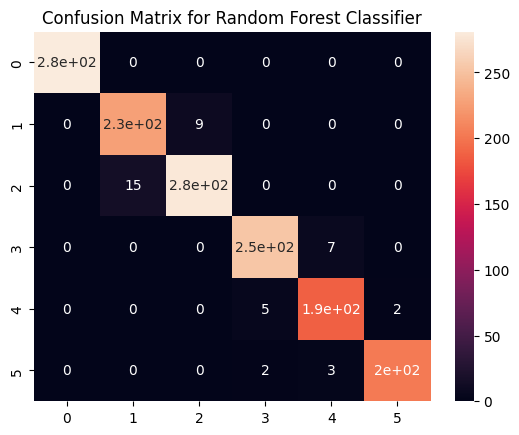

In [ ]:
# accuracy
print(f'Accuracy Score for Random Forest Classifier is {accuracy_score(y_test_f, y_rf)}\n')

# F1 score
print(f"F1 Score for Random Forest Classifier is {f1_score(y_test_f, y_rf, average='weighted')}\n")

# classification report
print(classification_report(y_rf, y_test_f))

# plot confusion matrix
rf_cm = confusion_matrix(y_test_f, y_rf)
ax=plt.axes()
sns.heatmap(rf_cm, annot=True, ax=ax)
ax.set_title('Confusion Matrix for Random Forest Classifier')

**KNN**

Accuracy Score for K-nearest neighbor is 0.972807613868117

F1 Score for K-nearest neighbor is 0.972807992344118

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       281
           1       0.93      0.93      0.93       237
           2       0.94      0.95      0.94       292
           3       1.00      0.98      0.99       264
           4       0.97      1.00      0.99       189
           5       1.00      0.99      0.99       208

    accuracy                           0.97      1471
   macro avg       0.97      0.97      0.97      1471
weighted avg       0.97      0.97      0.97      1471



Text(0.5, 1.0, 'Confusion Matrix for K-nearest neighbor')

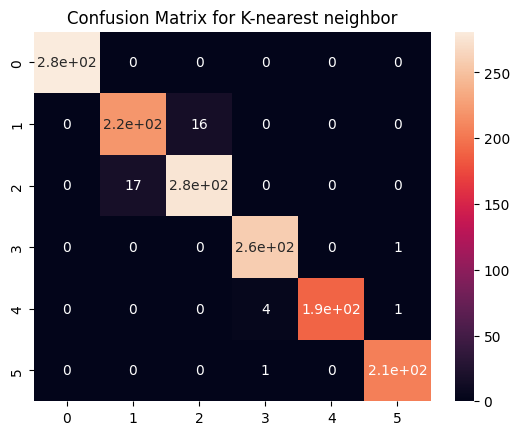

In [ ]:
# accuracy
print(f'Accuracy Score for K-nearest neighbor is {accuracy_score(y_test_f, y_knn)}\n')

# F1 score
print(f"F1 Score for K-nearest neighbor is {f1_score(y_test_f, y_knn, average='weighted')}\n")

# classification report
print(classification_report(y_knn, y_test_f))

# plot confusion matrix
knn_cm = confusion_matrix(y_test_f, y_knn)
ax=plt.axes()
sns.heatmap(knn_cm, annot=True, ax=ax)
ax.set_title('Confusion Matrix for K-nearest neighbor')

**SVM**

Accuracy Score for SVM is 0.946974847042828

F1 Score for SVM is 0.9469920400587126

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       281
           1       0.89      0.90      0.90       235
           2       0.92      0.91      0.92       294
           3       0.96      0.97      0.97       257
           4       0.93      0.97      0.95       187
           5       0.97      0.93      0.95       217

    accuracy                           0.95      1471
   macro avg       0.95      0.95      0.95      1471
weighted avg       0.95      0.95      0.95      1471



Text(0.5, 1.0, 'Confusion Matrix for SVM')

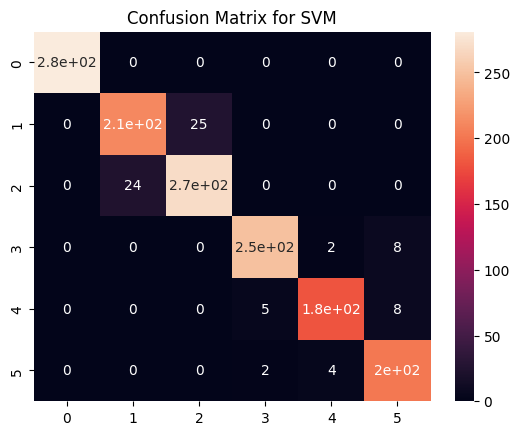

In [ ]:
# accuracy
print(f'Accuracy Score for SVM is {accuracy_score(y_test_f, y_svm)}\n')

# F1 score
print(f"F1 Score for SVM is {f1_score(y_test_f, y_svm, average='weighted')}\n")

# classification report
print(classification_report(y_svm, y_test_f))

# plot confusion matrix
svm_cm = confusion_matrix(y_test_f, y_svm)
ax=plt.axes()
sns.heatmap(svm_cm, annot=True, ax=ax)
ax.set_title('Confusion Matrix for SVM')

**AUROC and ROC curve**

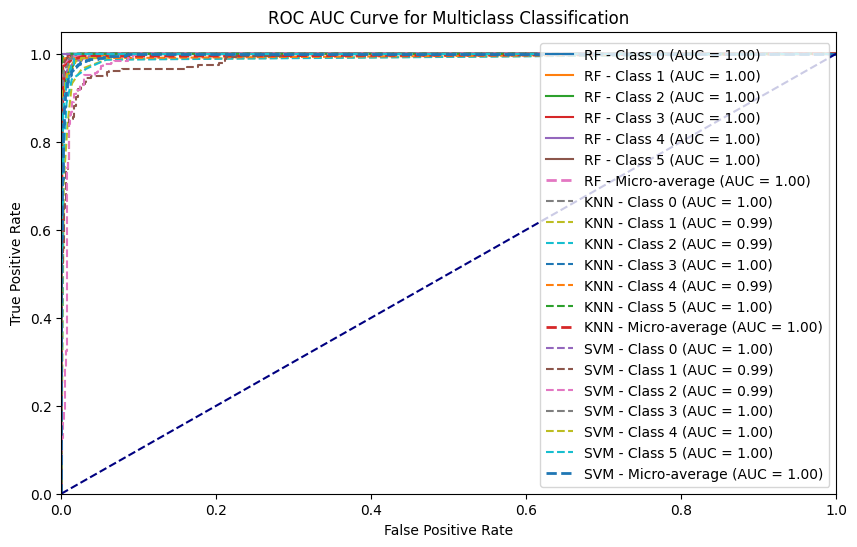

In [ ]:
# Predict probabilities for each class on the test set
y_probs_rf = model_rf.predict_proba(X_test_f)
y_probs_knn = model_k.predict_proba(X_test_f)
y_probs_svm = model_svm.predict_proba(X_test_f)

# Binarize the labels for multiclass ROC AUC
y_test_bin = label_binarize(y_test_f, classes=np.unique(y))

# Compute ROC curves and ROC areas for each class for the models
fpr_rf, tpr_rf, roc_auc_rf = dict(), dict(), dict()
fpr_knn, tpr_knn, roc_auc_knn = dict(), dict(), dict()
fpr_svm, tpr_svm, roc_auc_svm = dict(), dict(), dict()

n_classes = len(np.unique(y))
for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_bin[:, i], y_probs_rf[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test_bin[:, i], y_probs_knn[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])

    fpr_svm[i], tpr_svm[i], _ = roc_curve(y_test_bin[:, i], y_probs_svm[:, i])
    roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

# Compute micro-average ROC curves and ROC areas for the models
fpr_rf["micro"], tpr_rf["micro"], _ = roc_curve(y_test_bin.ravel(), y_probs_rf.ravel())
roc_auc_rf["micro"] = auc(fpr_rf["micro"], tpr_rf["micro"])

fpr_knn["micro"], tpr_knn["micro"], _ = roc_curve(y_test_bin.ravel(), y_probs_knn.ravel())
roc_auc_knn["micro"] = auc(fpr_knn["micro"], tpr_knn["micro"])

fpr_svm["micro"], tpr_svm["micro"], _ = roc_curve(y_test_bin.ravel(), y_probs_svm.ravel())
roc_auc_svm["micro"] = auc(fpr_svm["micro"], tpr_svm["micro"])

# Plot ROC curves for the models
plt.figure(figsize=(10, 6))

# Plot ROC curve for RandomForestClassifier
for i in range(n_classes):
    plt.plot(fpr_rf[i], tpr_rf[i], label=f'RF - Class {i} (AUC = {roc_auc_rf[i]:.2f})')

plt.plot(fpr_rf["micro"], tpr_rf["micro"], label=f'RF - Micro-average (AUC = {roc_auc_rf["micro"]:.2f})', linestyle='--', linewidth=2)

# Plot ROC curve for KNN
for i in range(n_classes):
    plt.plot(fpr_knn[i], tpr_knn[i], label=f'KNN - Class {i} (AUC = {roc_auc_knn[i]:.2f})', linestyle='--')

plt.plot(fpr_knn["micro"], tpr_knn["micro"], label=f'KNN - Micro-average (AUC = {roc_auc_knn["micro"]:.2f})', linestyle='--', linewidth=2)

# Plot ROC curve for Support Vector Machine
for i in range(n_classes):
    plt.plot(fpr_svm[i], tpr_svm[i], label=f'SVM - Class {i} (AUC = {roc_auc_svm[i]:.2f})', linestyle='--')

plt.plot(fpr_svm["micro"], tpr_svm["micro"], label=f'SVM - Micro-average (AUC = {roc_auc_svm["micro"]:.2f})', linestyle='--', linewidth=2)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

# **Hyperparameter tuning**

**Random forest classifier**

In [ ]:
# Grid search params for random forest classifier
rf_grid_params = {
    'max_depth': [80, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200, 1000]
}

grid_search_rf = GridSearchCV(estimator = model_rf, param_grid = rf_grid_params,
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search_rf.fit(X_train_f, y_train_f)
grid_search_rf.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'max_depth': 100,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}

In [ ]:
best_grid_rf = grid_search_rf.best_estimator_
print(best_grid_rf)
best_grid_rf.score(X_train_f, y_train_f)

RandomForestClassifier(max_depth=100, max_features=3, min_samples_leaf=3,
                       min_samples_split=8, n_estimators=1000)


0.9942186702941677

In [ ]:
y_best_rf=best_grid_rf.predict(X_test_f)

# accuracy
print(f'Accuracy Score for random forest after tuning is {accuracy_score(y_test_f, y_best_rf)}\n')

# F1 score
print(f"F1 Score for random forest after tuning is {f1_score(y_test_f, y_best_rf, average='weighted')}\n")

# classification report
print(classification_report(y_best_rf, y_test_f))

Accuracy Score for random forest after tuning is 0.9666893269884432

F1 Score for random forest after tuning is 0.9667089857958362

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       281
           1       0.94      0.94      0.94       235
           2       0.95      0.95      0.95       294
           3       0.97      0.97      0.97       261
           4       0.96      0.95      0.95       196
           5       0.98      0.99      0.98       204

    accuracy                           0.97      1471
   macro avg       0.97      0.97      0.97      1471
weighted avg       0.97      0.97      0.97      1471



**KNN**

In [ ]:
# Grid search params for KNN
knn_grid_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

grid_search_knn = GridSearchCV(estimator = model_k, param_grid = knn_grid_params,
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search_knn.fit(X_train_f, y_train_f)
grid_search_knn.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

In [ ]:
best_grid_knn = grid_search_knn.best_estimator_
print(best_grid_knn)
best_grid_knn.score(X_train_f, y_train_f)

KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')


1.0

In [ ]:
y_best_knn=best_grid_knn.predict(X_test_f)

# accuracy
print(f'Accuracy Score for KNN after tuning is {accuracy_score(y_test_f, y_best_knn)}\n')

# F1 score
print(f"F1 Score for KNN after tuning is {f1_score(y_test_f, y_best_knn, average='weighted')}\n")

# classification report
print(classification_report(y_best_knn, y_test_f))

Accuracy Score for KNN after tuning is 0.9809653297076818

F1 Score for KNN after tuning is 0.9809533060688972

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       281
           1       0.94      0.96      0.95       233
           2       0.97      0.96      0.96       296
           3       1.00      0.99      0.99       262
           4       0.98      0.99      0.99       192
           5       1.00      1.00      1.00       207

    accuracy                           0.98      1471
   macro avg       0.98      0.98      0.98      1471
weighted avg       0.98      0.98      0.98      1471

